In [62]:
# Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [63]:
df_raw = pd.read_csv('kredit.csv')

In [64]:
df = df_raw.copy(deep=True)

In [65]:
df['zahlung pro monat'] = df['hoehe'] / df['laufzeit']

In [66]:
X = df.drop('kredit', axis=1)
y = df['kredit']

In [67]:
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=42, stratify= y)

In [68]:
X_eval, X_test, y_eval, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42, stratify= y_other)

## Feature Selection Chi Squared + ANOVA

In [69]:
categorical_columns = ['laufkont', 'moral', 'verw', 'sparkont', 'beszeit',
       'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'weitkred',
       'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb']

numerical_columns = [col for col in df.columns[1:] if col not in categorical_columns]

X_train_cat = X_train[categorical_columns]
X_train_num = X_train[numerical_columns]

### Chi Squared

In [71]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('P-Wert',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['P-Wert'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,P-Wert
0,laufkont,0.000000e+00
1,moral,8.930000e-08
2,sparkont,7.808000e-07
3,verw,6.418766e-04
4,verm,7.100809e-04
5,wohn,2.433382e-03
6,weitkred,3.997826e-03
7,gastarb,6.407223e-03
8,buerge,4.497301e-02
9,beszeit,6.039272e-02


In [61]:
X_train_num.shape,y_train.shape

((700, 4), (700,))

### ANOVA

In [72]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Continuous Features': X_train_num.columns.values, 'F-Score': F_statistic, 'P-Wert': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Continuous Features,F-Score,P-Wert
0,laufzeit,29.371354,8.240000e-08
1,hoehe,16.070181,6.760870e-05
2,alter,1.888618,1.697990e-01
3,zahlung pro monat,0.461666,4.970715e-01


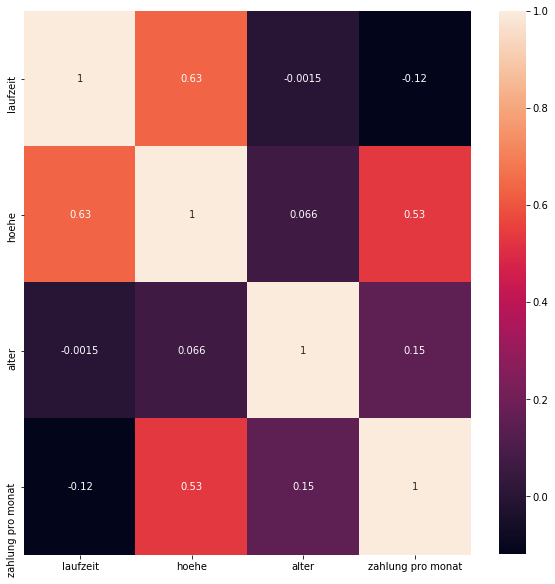

In [73]:
top_num_features = ANOVA_F_table.iloc[:,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, annot=True);

### Choose 3 most significant features on categorical variable

In [74]:
drop_columns_list = chi2_result.iloc[4:, 0].to_list()

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

E:\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Use all numerical feature

In [75]:
col_to_drop(X_test, drop_columns_list)

In [48]:
8.930000e-08 < 8.240000e-08

False

In [49]:
0.05 >8.930000e-08

True

In [50]:
8.930000e-08 > 7.808000e-07

False

In [51]:
df.describe()

,kredit,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,zahlung pro monat
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,...,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000,167.685413
std,0.458487,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,...,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,153.492003
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,...,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.055556
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,...,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,89.331250
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,...,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,130.333333
75%,1.000000,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,...,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,206.183333
max,1.000000,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,...,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2482.666667


In [79]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 8), (700,), (150, 8), (150,))